In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import roc_curve, auc,roc_auc_score
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures



#set datadir based on cwd
cwd = os.getcwd()
#OSX
datadir = cwd + '/data/'
df = pd.read_csv(datadir+'data_clean.csv',index_col=0)

#Windows
#datadir = cwd + '\\data\\'
#df = pd.read_csv(datadir+'data_clean.csv')

<h3>Part 1: Separate training and test data<h3/>

In [3]:
train_df = df.sample(frac=0.7, replace=False)
test_df = df[~df.index.isin(train_df.index)]
#check if train_df and test_df overlap
len(train_df) + len(test_df) == len(df)

True

<h3>Part 2: Feature Exploration<h3/>



In this section, we only explore the features in a general way. We check the individual auc_score and mi score

In [79]:
#Declare target variable, training data and testing data
target = 'NewArrest36'
train = train_df
test = test_df

#Set up X Y
X_train = train.drop(target, 1)
Y_train = train[target]
X_test = test.drop(target, 1)
Y_test = test[target]

In [5]:
#Create the function to calculate and return auc score
def AUCCal(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label = str(col) + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    return roc_auc    


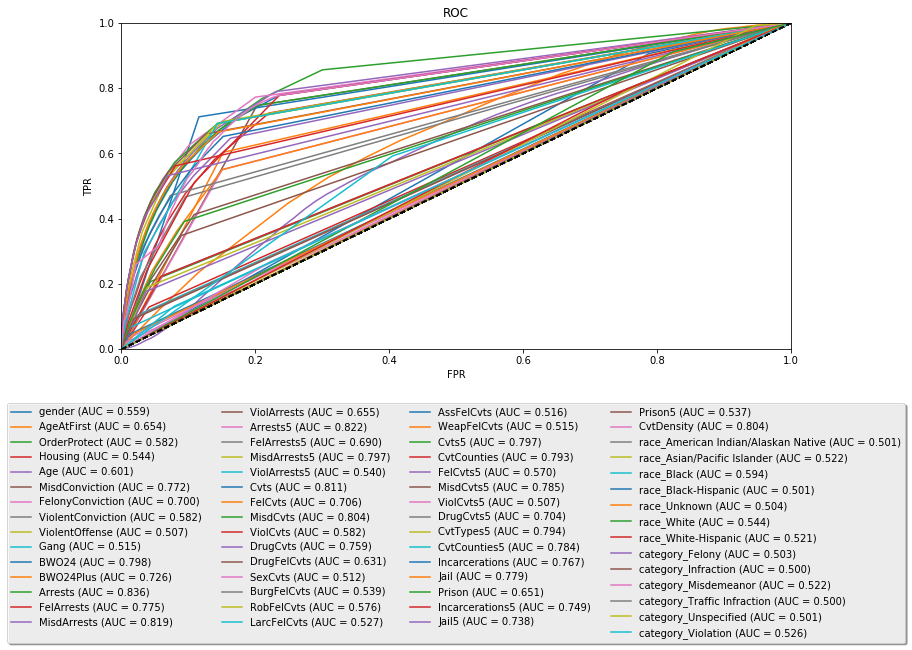

In [6]:
#Check auc scores for all features
featureset = list(X_train.columns.values)
feature_auc_dict = {}


fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
#create a plot and set some options
for col in X_train.columns:
    feature_auc_dict[col] = AUCCal(X_train[col],Y_train,col)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
    

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [7]:
#calculate mi for each feature 
feature_mi = mutual_info_classif(X_train,Y_train)
feature_mi_dict = dict(zip(X_train.columns.values, feature_mi))

#Add auc and mi each to a single dataframe
df_auc = pd.DataFrame(pd.Series(feature_auc_dict), columns = ['auc'])
df_mi = pd.DataFrame(pd.Series(feature_mi_dict), columns = ['mi'])   

#Now merge the two on the feature name
feat_imp_df = df_auc.merge(df_mi, left_index = True, right_index = True)
feat_imp_df

,auc,mi
Age,0.601074,0.021332
AgeAtFirst,0.653501,0.038681
Arrests,0.835728,0.197698
Arrests5,0.822415,0.202124
AssFelCvts,0.516481,0.004622
BWO24,0.798080,0.196692
BWO24Plus,0.725613,0.115117
BurgFelCvts,0.539056,0.011673
CvtCounties,0.792618,0.160631
CvtCounties5,0.784101,0.167720


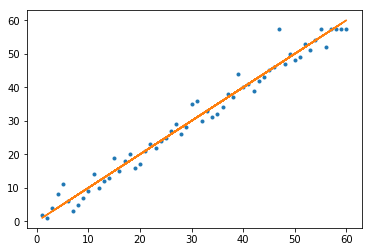

In [8]:
#Now create a df that holds the ranks of auc and mi 
feat_ranks = feat_imp_df.rank(axis = 0, ascending = False)
#Plot the two ranks
plt.plot(feat_ranks.auc, feat_ranks.mi, '.')
#Plot a y=x reference line
plt.plot(feat_ranks.auc, feat_ranks.auc,)

We could tell from the cruve above that, the rank of auc and rank of mi forms a linear line. When x is smaller than 30, we could see that the data points fit the linear line much better than x > 30. In the next plot, we can compare top n features in AUC and MI and see how big the discrepancy is.

<h3>Part 3: Building First Models with Top features in auc and mi <h3/>

Since we have no idea how many features we should choose for the first model, with the individual auc scores, we first build the model with top 30 features to see how it performs.Even though we have no idea how to set the thredshold, we coul test it in next step.

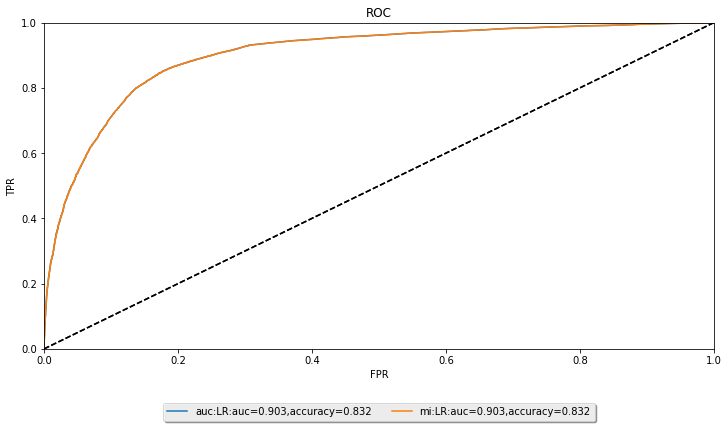

In [12]:
featureset_1_auc = list(feat_ranks[(feat_ranks.auc <= 30)].index.values)
featureset_1_mi = list(feat_ranks[(feat_ranks.mi <= 30)].index.values)

fsets = [featureset_1_auc, featureset_1_mi]
fset_descr = ['auc', 'mi']


#Plot
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

for i, fset in enumerate(fsets):
    descr = fset_descr[i]
    #set training and testing data
    X_train_1 = X_train[fset]
    X_test_1 = X_test[fset]

    #Buil Logistic Regression
    logreg1 = LogisticRegression()
    logreg1.fit(X_train_1,Y_train)
    preds_logreg1 = logreg1.predict_proba(X_test_1)[:, 1]

    fpr1, tpr1, thresholds1 = roc_curve(Y_test,preds_logreg1)
    roc_auc1 = roc_auc_score(Y_test,preds_logreg1)
    accuracy1 = logreg1.score(X_test_1, Y_test)
    
    plt.plot(fpr1, tpr1, label = '{}:LR:auc={},accuracy={}'.format(descr, round(roc_auc1, 3), round(accuracy1, 3)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

Two models have the same auc scores and accuracy score, so that in the following steps, we will only use auc scores to select features.<br/>
With Top 30 features, our first LR model has AUC 0.903 and Accuracy_Score = 0.832. It seems to be a good number, but with too many features, the model will be more complicated. To control the complexity, in the next step, we use two different methods to select features 

<h3>Part 3: Feature Selection</h3> 

<h4>Method 1: NAÏVE SUBSET SELECTION </h4>

In [13]:
#we want to see how model will improve with more top features added.
#we test feaetures in step of 5. Top 5, top 10, top 15...features
feature_test_step = np.arange(5,65,5)

featuresetname = list()
featureset = list()
for i in feature_test_step:
    featuresetname.append('feature_top_'+str(i))
    featureset.append(feat_ranks[(feat_ranks.auc <= i)].index.values)
    
feature_dict = dict(zip(featuresetname,featureset))

In [14]:
#create the function to compare the number of top n features we use to build the model
#and return the auc_score and accuracy_score
def FeatureCompare(featureset,featuresetname):
    X_train_2 = X_train[featureset]
    X_test_2 = X_test[featureset]

    #Model1:Logistic Regression
    logreg = LogisticRegression()
    logreg.fit(X_train_2,Y_train)
    preds_logreg = logreg.predict_proba(X_test_2)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(Y_test,preds_logreg)
    roc_auc = roc_auc_score(Y_test,preds_logreg)
    accuracy = logreg.score(X_test_2, Y_test)
    
    plt.plot(fpr, tpr, label = featuresetname + '(AUC = %0.3f,Accuracy=%0.3f)' % (roc_auc,accuracy))
    
    return roc_auc,accuracy

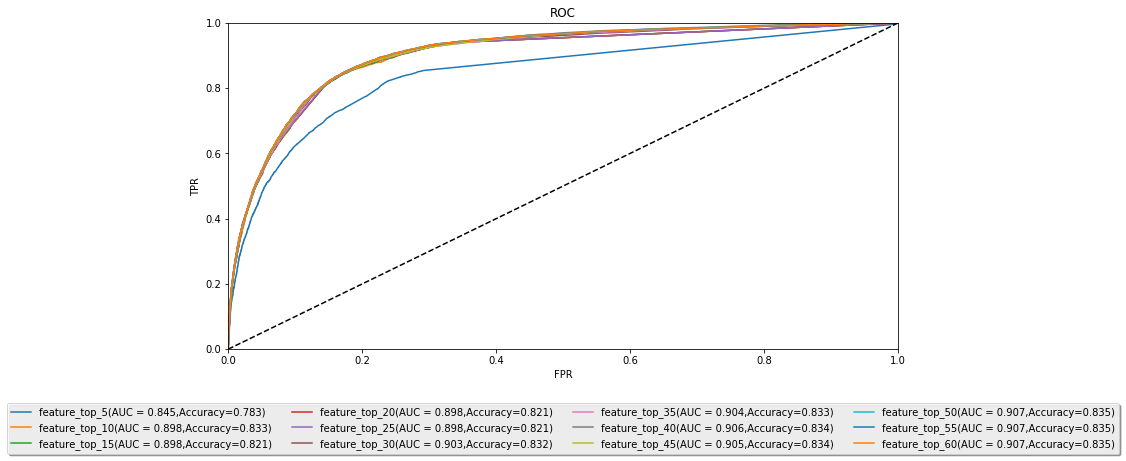

In [15]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

auc_dict = dict()
accuracy_dict = dict()

for key in feature_dict.keys():
    auc_dict[key],accuracy_dict[key] = FeatureCompare(feature_dict[key],key)

    

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

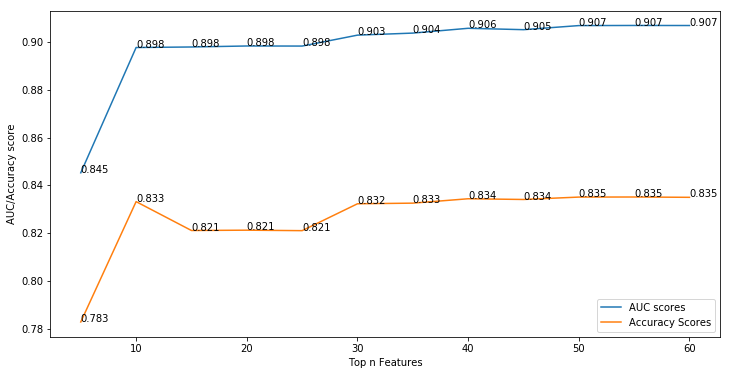

In [16]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

plt.plot(feature_test_step,list(auc_dict.values()),label="AUC scores")
plt.plot(feature_test_step,list(accuracy_dict.values()),label="Accuracy Scores")

for a,b in zip(feature_test_step, list(auc_dict.values())): 
    plt.text(a, b, str('%.3f' %b))
    
for a,b in zip(feature_test_step, list(accuracy_dict.values())): 
    plt.text(a, b, str('%.3f' %b))
    
ax.set_xlabel('Top n Features')
ax.set_ylabel('AUC/Accuracy score')
plt.legend(loc="lower right")

From the ROC_AUC curve above, we could tell that, the more top features we use, the higher auc score we get, however, it doesn't help us improve the model. After top 30 features, even though that with more features, auc and accuracy grows, the model gets more complex. The best model we get from this feature selection method is LR model with top 50 features with auc = 0.907 and accuracy_score = 0.835. Compared to the first model with top 30 features, even though it has better auc and accuracy score, its more complex. Therefore, we have to try another way of feature selection<br/>

<h4>Method 2:FORWARD STEPWISE SELECTION </h4>

In this part, it takes a long time(~ 60min) to run the forward stepwise feature selection function.

In [19]:
#Define two functions to calculate the logloss and the forward_loss
def LR_LogLoss(cv, X_train, Y_train):
    ll = []
    
    for train_index, test_index in cv.split(X_train):
        X_train_f = X_train.iloc[train_index]
        X_vali_f = X_train.iloc[test_index]
        Y_train_f = Y_train.iloc[train_index]
        Y_vali_f = Y_train.iloc[test_index]
        
        logreg = LogisticRegression()
        logreg.fit(X_train_f, Y_train_f)
        P = logreg.predict_proba(X_vali_f)[:,1]
        
        #to avoid log 0
        P[P == 0] = 10**(-10)
        P[P == 1] = 99.**(-10)
        
        #calculate logloss and append to the list
        ll.append(-1*(((Y_vali_f==1)*np.log(P)+(Y_vali_f==0)*np.log(1-P)).mean()))
        
    mu = np.array(ll).mean()
    serr = np.array(ll).std()/np.sqrt(len(ll))
    
    return mu,serr

def LR_Forward_Loss(X_train,Y_train,cv):
    Curr_Best_Subset = set([])
    results = {}
    FeatureList = set(X_train.columns)
    k = 1
    
    while (len(FeatureList)>0):
        best_mu = 10**10
        best_serr = 10**10
        
        for f in FeatureList:
            feature_to_use = list(Curr_Best_Subset)+[f]
            mu,serr = LR_LogLoss(cv, X_train[feature_to_use], Y_train)
            if ((mu + serr) < (best_mu + best_serr)):
                best_mu = mu
                best_serr = serr
                best_f = f
                
                
        Curr_Best_Subset.add(best_f) #Add the best feature to the curr_best_set
        FeatureList = FeatureList.difference(Curr_Best_Subset) #Remove the best feature from the candidate set
        results[k] = [list(Curr_Best_Subset), best_mu, best_serr]
        k+=1
    return results

In [20]:
#Run the forward selection
cv = KFold(n_splits = 5)
r = LR_Forward_Loss(X_train, Y_train, cv)

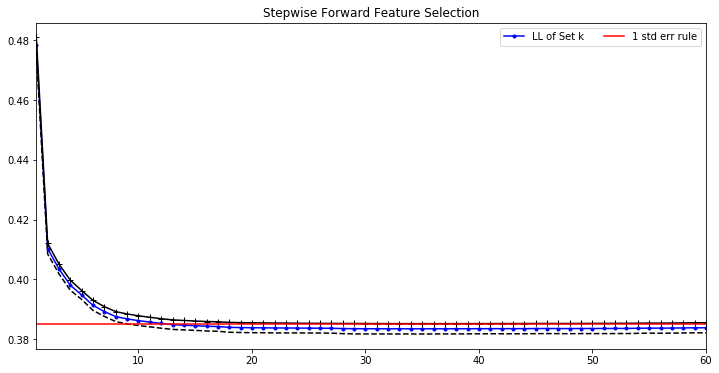

In [21]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

ks = []; mus = []; serrs = [];
for i in range(len(r.keys())):
    ks.append(i+1)
    mus.append(r[i+1][1])
    serrs.append(r[i+1][2])

    
best_1serr = min(np.array(mus) + np.array(serrs))
plt.clf()
plt.plot(ks, mus, 'b.-', label = 'LL of Set k')
plt.plot(ks, np.array(mus) + np.array(serrs), 'k+-')
plt.plot(ks, np.array(mus) - np.array(serrs), 'k--')
plt.plot(ks, np.ones(len(ks))*best_1serr, 'r', label ='1 std err rule')

plt.xlim([1,60])

plt.title('Stepwise Forward Feature Selection')
ax.set_xlabel('Greedily Selected Subset of Size k')
ax.set_ylabel('X Validated LogLoss')
    
plt.legend(loc=1, ncol=2)
plt.show()

From the curve above, we could see that as size k goes bigger, from 0 to 30, logloss decreases, and after 30, logloss seems to be plateau. By looking at the red line, we want the error less than the red line (mean + 1 std error), therefore, we pick k = 15. 

We will choose k = 17 as the best feature sets.<br/>

<h3> Part 4: Building 3rd LR Model with selected 17 features </h3>

In [22]:
#define a function to build LR model and return auc and accuracy scores
def BuildLRModel(X_train,X_test,Y_train,Y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train,Y_train)
    preds_logreg = logreg.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(Y_test,preds_logreg)
    roc_auc = roc_auc_score(Y_test,preds_logreg)
    accuracy = logreg.score(X_test, Y_test)
    
    
    return fpr,tpr,roc_auc,accuracy

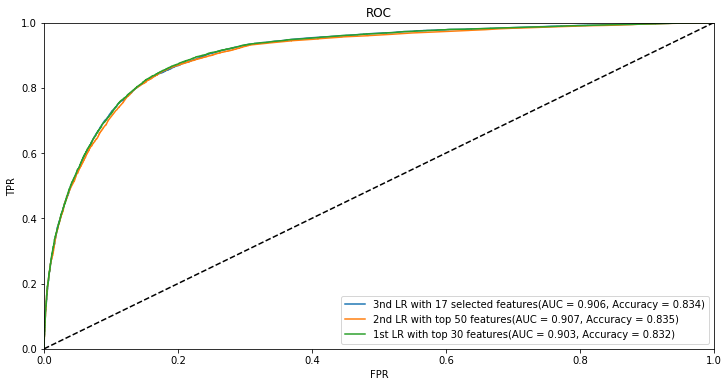

In [41]:
#Logistic Regression with selected 15 features
featureset_3 = r[17][0]
fpr3, tpr3,roc_auc3, accuracy3 = BuildLRModel(X_train[featureset_3],X_test[featureset_3],Y_train,Y_test)

#Logistic Regression with top 30 features
fpr2, tpr2,roc_auc1, accuracy1 = BuildLRModel(X_train[featureset_1_auc],X_test[featureset_1_auc], Y_train,Y_test)

#Logistic Regression with top 50 features (with the best auc and accuracy in naive feature selection model)
featureset_2_auc = list(feat_ranks[(feat_ranks.auc <= 50)].index.values)
fpr1, tpr1,roc_auc2, accuracy2 = BuildLRModel(X_train[featureset_2_auc],X_test[featureset_2_auc],Y_train,Y_test)

#Plot
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

plt.plot(fpr3, tpr3, label = '3nd LR with 17 selected features(AUC = %0.3f, Accuracy = %0.3f)' % (roc_auc3,accuracy3))
plt.plot(fpr2, tpr2, label = '2nd LR with top 50 features(AUC = %0.3f, Accuracy = %0.3f)' % (roc_auc2,accuracy2))
plt.plot(fpr1, tpr1, label = '1st LR with top 30 features(AUC = %0.3f, Accuracy = %0.3f)' % (roc_auc1,accuracy1))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")

Compare the auc_score and accuracy_score for these three models, with 20 features, model 3 has the same auc and accuracy with model 2 which has 50 features, however, to control the complexity, we choose model 3. So we ended up using model3, Logistic Regression Model with 15 selected features using Forward Stepwise Feature Selection method, as our final LR model. 

<h3> Test Hyperparameters in LR </h3>

In [44]:
#Step 1: Finalize the train and test data with selected features above
X_train_lr = X_train[featureset_3]
X_test_lr = X_test[featureset_3]
Y_train_lr = Y_train
Y_test_lr = Y_test

#Use Kfold to create 10 folds
cv = KFold(n_splits = 10)

In [45]:
#1st, set up a paramater grid
param_grid_lr = {'C':[10**i for i in range(-4, 4)], 'penalty':['l1', 'l2']}

#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv = cv, scoring = 'roc_auc') 
lr_grid_search.fit(X_train_lr,Y_train_lr)

#3rd, get the score of the best model and print it
best_1 = lr_grid_search.best_score_
print(best_1)

0.906043113756


In [46]:
lr_grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
steps = [('scaler', StandardScaler()),
         ('lr', LogisticRegression())]

#Now set up the pipeline
pipeline = Pipeline(steps)

#Now set up the parameter grid, paying close to the correct convention here
parameters_scaler = dict(lr__C = [10**i for i in range(-4, 4)],
                  lr__penalty = ['l1', 'l2'])

#Now run another grid search
lr_grid_search_scaler = GridSearchCV(pipeline, param_grid = parameters_scaler, cv = cv, scoring = 'roc_auc')
lr_grid_search_scaler.fit(X_train_lr, Y_train_lr)


#Again, print the score of the best model
best_2 = lr_grid_search_scaler.best_score_
print(best_2)

0.906071501929


Be carefule about the following part. Takes around 40 min.

In [40]:
#Create a set of steps. All but the last step is a transformer (something that processes data). 
# Step 1 - PolynomialFeatures
# Step 2 - StandardScaler
# Step 3 - LogisticRegression

steps_poly = [('polyfeat', PolynomialFeatures()),
         ('scaler', StandardScaler()),
         ('lr', LogisticRegression())]

#Now set up the pipeline
pipeline_poly = Pipeline(steps_poly)

#Now set up a new parameter grid, use the same paramaters used above for logistic regression, but add polynomial features up to degree 3. 
parameters_poly = dict(polyfeat__degree = [1, 2],
                       polyfeat__interaction_only = [True, False],
                       lr__C = [10**i for i in range(-4, 4)],
                       lr__penalty = ['l1', 'l2'])

#Now run another grid search
lr_grid_search_poly = GridSearchCV(pipeline_poly, param_grid = parameters_poly, cv = cv, scoring = 'roc_auc')

lr_grid_search_poly.fit(X_train_lr, Y_train_lr)
best_3 = lr_grid_search_poly.best_score_
print(best_3)

0.910159721924


In [144]:
lr_grid_search_poly.best_estimator_.steps

[('polyfeat',
  PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)),
 ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('lr',
  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

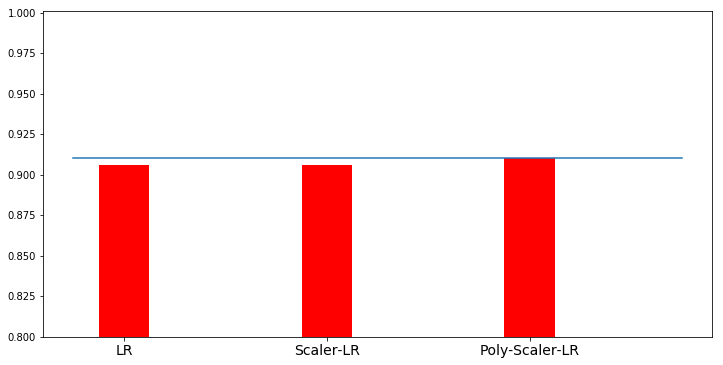

In [52]:
results = np.array([best_1, best_2, best_3])
labs = ['LR', 'Scaler-LR', 'Poly-Scaler-LR']

fig = plt.figure(facecolor = 'w', figsize = (12, 6))
ax = plt.subplot(111)

width = 0.25
ind = np.arange(3)
rec = ax.bar(ind + width, results, width, color='r')

ax.set_xticks(ind + width)
ax.set_xticklabels(labs, size = 14)
ax.set_ylim([0.8, max(results)*1.1])

plt.plot(np.arange(4), max(results) * np.ones(4))

In [53]:
BuildLRModel(X_train_lr,X_test_lr,Y_train_lr,Y_test_lr)

(array([  0.00000000e+00,   0.00000000e+00,   5.56575945e-05, ...,
          9.99666054e-01,   9.99777370e-01,   1.00000000e+00]),
 array([  8.34097923e-05,   3.83685045e-03,   3.83685045e-03, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]),
 0.90630120568908157,
 0.83425691013486447)

In [56]:
logreg1 = LogisticRegression(C = 0.1)
logreg1.fit(X_train_lr,Y_train_lr)
preds_logreg1 = logreg1.predict_proba(X_test_lr)[:, 1]

fpr1, tpr1, thresholds = roc_curve(Y_test_lr,preds_logreg1)
roc_auc1 = roc_auc_score(Y_test_lr,preds_logreg1)
accuracy1 = logreg.score(X_test_lr, Y_test_lr)

In [63]:
scaler = StandardScaler()
logreg2 = LogisticRegression(C = 0.1)
X = scaler.fit_transform(X_train_lr)
X_test = scaler.fit_transform(X_test_lr)
logreg2.fit(X,Y_train_lr)
preds_logreg2 = logreg2.predict_proba(X_test)[:, 1]

fpr2, tpr2, thresholds = roc_curve(Y_test_lr,preds_logreg2)
roc_auc2 = roc_auc_score(Y_test_lr,preds_logreg2)
accuracy2 = logreg.score(X_test, Y_test_lr)

In [84]:
feature_test_step = np.arange(20,65,5)

featuresetname = list()
featureset = list()
for i in feature_test_step:
    featuresetname.append('feature_top_'+str(i))
    featureset.append(feat_ranks[(feat_ranks.auc <= i)].index.values)
    
feature_dict = dict(zip(featuresetname,featureset))

In [91]:
def FeatureCompare2(featureset,featuresetname):
    X_train_2 = X_train[featureset]
    X_test_2 = X_test[featureset]

    #Model2:Random Forest
    rf_def = RandomForestClassifier(criterion='entropy')
    rf_def = rf_def.fit(X_train_2, Y_train)
    rf_pred =rf_def.predict_proba(X_test_2)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(Y_test,rf_pred)
    roc_auc = roc_auc_score(Y_test,rf_pred)
    #accuracy = logreg.score(X_test_2, Y_test)
    
    plt.plot(fpr, tpr, label = featuresetname + '(AUC = %0.3f,Accuracy=%0.3f)' % (roc_auc,accuracy))
    
    return roc_auc

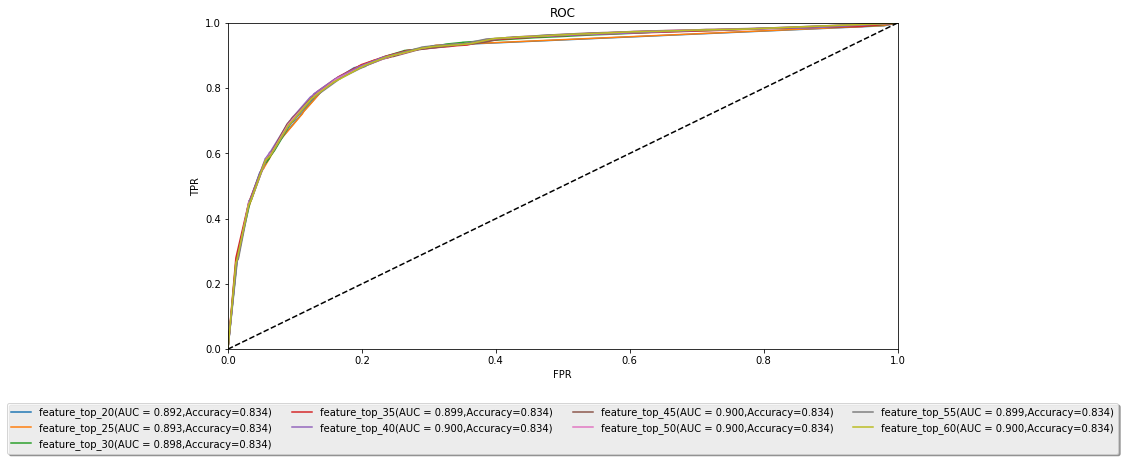

In [92]:
from sklearn.ensemble import RandomForestClassifier
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

auc_dict = dict()
accuracy_dict = dict()

for key in feature_dict.keys():
    auc_dict[key] = FeatureCompare2(feature_dict[key],key)

    

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})